Questions for TA: 

Why isn't total column being recognized?

How do you plot OLS results?

In [190]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import csv
import urllib2
import numpy as np
# import zipfile as zp
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Importing Energy_and_Water_Data_Disclosure_for_Local_Law_84 Data

In [191]:
url = 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
response = urllib2.urlopen(url)
energy = gp.GeoDataFrame.from_csv(response)

# creating simpler variable name for later
energy['BBL'] = energy['NYC Borough, Block, and Lot (BBL)']
energy['EUI'] = energy['Site EUI(kBtu/ft2)']

print energy.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings',
       u'BBL', u'EUI'],
      dtype='object')


### Importing PLUTO Data

In [192]:
# url2 = 'http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/mn_mappluto_15v1.zip'
# response2 = urllib2.urlopen(url2)
# #  = zp.ZipFile.open(name[, mode[, pwd]])

# zipped = zp.ZipFile(response2, 'r')
# pluto = zipped.open('Manhattan/MNMapPLUTO.shp')

In [193]:
pluto = gp.GeoDataFrame.from_file(os.getenv('PUI2015')+'/HW5/Manhattan/MNMapPLUTO.shp')
print pluto.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [194]:
# from pandas.tools.plotting import scatter_matrix
# scatter_matrix (energy, s=300, figsize=(12, 12), diagonal='kde')

### Data Cleanup

In [195]:
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    
fun = np.vectorize(canconvert)

In [196]:
index_units = fun(pluto['UnitsTotal'])
pluto['UnitsTotal'][~index_units] = float('NaN')
pluto['UnitsTotal'] = [float(x) for x in pluto['UnitsTotal']]

index_pbbl = fun(pluto['BBL'])
pluto['BBL'][~index_pbbl] = float('NaN')
pluto['BBL'] = [str(x) for x in pluto['BBL']]

index_area = fun(energy['Reported Property Floor Area (Building(s)) (ft²)'])
energy['Reported Property Floor Area (Building(s)) (ft²)'][~index_area] = float('NaN')
energy['Reported Property Floor Area (Building(s)) (ft²)'] = [float(x) for x in energy['Reported Property Floor Area (Building(s)) (ft²)']]

index_use = fun(energy['EUI'])
energy['EUI'][~index_use] = float('NaN')
energy['EUI'] = [float(x) for x in energy['EUI']]

index_ebbl = fun(energy['BBL'])
energy['BBL'][~index_ebbl] = float('NaN')
energy['BBL'] = [str(x) for x in energy['BBL']]

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: SettingWithCopyWarning

In [256]:
# print energy.EUI
# print energy.BBL
# print energy['Reported Property Floor Area (Building(s)) (ft²)']
# print pluto.BBL
# print pluto.UnitsTotal

###Merging the two data sets using the BBL

In [264]:
joined = pd.merge(energy,pluto,on=['BBL'],how='inner')
len(joined.BBL)

6545

In [269]:
# adding new column with total consumption/building
joined.total = []
joined.total = joined.EUI*joined['Reported Property Floor Area (Building(s)) (ft²)']

print joined.total

0       1.932388e+07
1       8.923786e+06
2       6.484985e+06
3       7.252000e+06
4       2.657421e+07
5       8.313213e+06
6       2.606125e+10
7       4.507029e+07
8       8.861394e+05
10      6.721880e+06
11      1.571334e+07
12      8.304709e+06
13      7.611074e+07
14      8.857581e+07
15      7.286018e+06
16      5.401410e+06
17      6.619960e+06
18      1.715440e+06
19      4.870652e+06
21      3.643200e+06
22      4.235712e+07
23      8.150267e+06
24      4.539942e+06
25      4.937273e+06
26      4.323671e+07
28      1.368137e+07
30      2.488650e+07
31      2.246201e+08
32      1.799610e+08
33      6.694794e+07
            ...     
5744    1.686385e+07
5746    6.477900e+06
5747    5.338200e+06
5748    5.600700e+06
5749    1.273500e+07
5751    7.176300e+06
5755    5.725514e+06
5757    7.667564e+06
5760    1.050000e+05
5764    1.141300e+07
5765    1.478448e+05
5766    2.693200e+05
5767    5.208080e+06
5768    1.356800e+05
5769    4.977000e+06
5771    4.300339e+07
5772    4.296

### Additional cleanup - removing outliers

In [266]:
joined = joined[joined.total>0]
len(joined.BBL)

5083

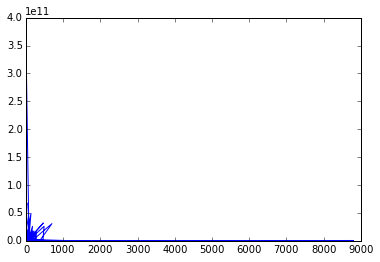

In [270]:
plot(joined.UnitsTotal, joined.total)

###Finding linear regression model

In [273]:
X = sm.add_constant(np.log10(joined.UnitsTotal))
print X
mmod = sm.OLS(np.log10(joined.total), X, missing='drop').fit() # ignores entires where x or y is NaN
print mmod.summary()

# fit = mmod.fit()
# return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse

      const  UnitsTotal
0         1    1.380211
1         1    1.792392
2         1    1.929419
3         1    2.107210
4         1    1.000000
5         1    1.785330
6         1    2.686636
7         1    2.656098
8         1    1.000000
10        1    1.832509
11        1    1.949390
12        1    0.954243
13        1    1.579784
14        1    0.698970
15        1    1.857332
16        1    1.748188
17        1    1.792392
18        1    1.977724
19        1    1.785330
21        1    1.785330
22        1    2.720986
23        1    1.724276
24        1    1.633468
25        1    1.819544
26        1    2.290035
28        1    1.623249
30        1    2.404834
31        1    1.716003
32        1    0.845098
33        1    0.954243
...     ...         ...
5744      1    1.875061
5746      1    0.000000
5747      1    0.000000
5748      1    0.000000
5749      1        -inf
5751      1    1.000000
5755      1    0.903090
5757      1    2.096910
5760      1    1.579784
5764      1    0

In [262]:
# fit and plots here

In [129]:
# try making a fit for energy vs units AND a fit for units vs energy. tell me which is better.
# look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [263]:
# now fit a second degree curve to it: ax^2+bx+c.
np.polyfit(joined.UnitsTotal, joined.total, 2)
# or statmodels.formula.api passing a formula like
# formula = 'y ~ 1 + x + I(x ^ 2.0)'   

AttributeError: 'DataFrame' object has no attribute 'total'

In [131]:
# look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??